In [1]:
import os, torch, shutil, numpy as np, pandas as pd
from glob import glob; from PIL import Image
from torch.utils.data import random_split, Dataset, DataLoader
from torchvision import transforms as T
from sklearn.metrics import accuracy_score
from torch import optim
import data

In [2]:
root = "e-commerce-products-images"
mean, std, im_size = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225], 224
tfs = T.Compose([T.Resize((im_size, im_size)), T.ToTensor(), T.Normalize(mean = mean, std = std)])
tr_dl, val_dl, ts_dl, classes = data.get_dls(root = root, transformations = tfs, bs = 32)

print(len(tr_dl)); print(len(val_dl)); print(len(ts_dl)); print(classes)

1250
70
2223
{'Topwear': 0, 'Bottomwear': 1, 'Watches': 2, 'Socks': 3, 'Shoes': 4, 'Belts': 5, 'Flip Flops': 6, 'Bags': 7, 'Innerwear': 8, 'Sandal': 9, 'Shoe Accessories': 10, 'Fragrance': 11, 'Jewellery': 12, 'Lips': 13, 'Saree': 14, 'Eyewear': 15, 'Nails': 16, 'Scarves': 17, 'Dress': 18, 'Loungewear and Nightwear': 19, 'Wallets': 20, 'Apparel Set': 21, 'Headwear': 22, 'Mufflers': 23, 'Skin Care': 24, 'Makeup': 25, 'Free Gifts': 26, 'Ties': 27, 'Accessories': 28, 'Skin': 29, 'Beauty Accessories': 30, 'Water Bottle': 31, 'Eyes': 32, 'Bath and Body': 33, 'Gloves': 34, 'Sports Accessories': 35, 'Cufflinks': 36, 'Sports Equipment': 37, 'Stoles': 38, 'Hair': 39, 'Perfumes': 40, 'Home Furnishing': 41, 'Umbrellas': 42, 'Wristbands': 43, 'Vouchers': 44}


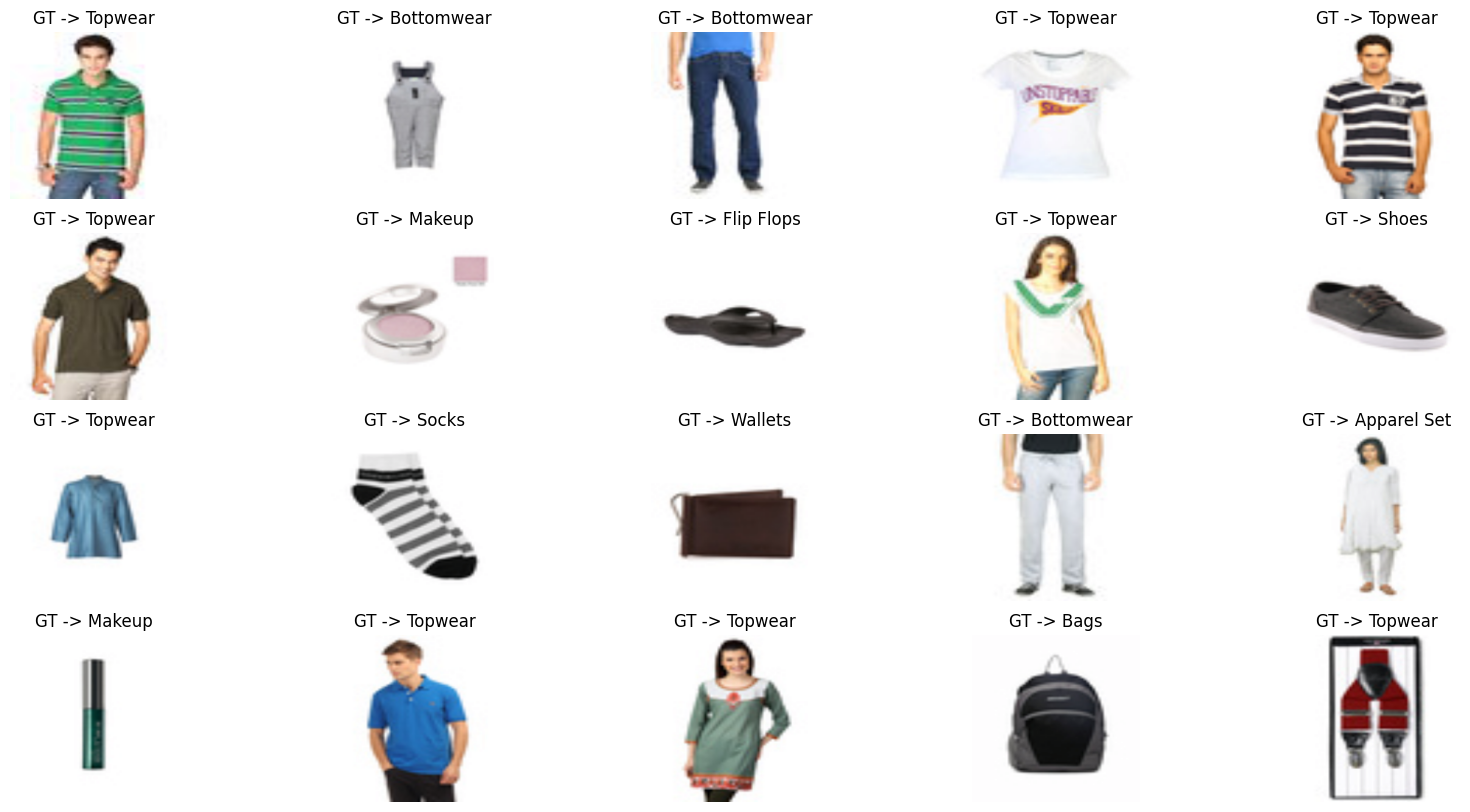

In [3]:
import random
from matplotlib import pyplot as plt

def tensor_2_im(t, t_type = "rgb"):
    
    gray_tfs = T.Compose([T.Normalize(mean = [ 0.], std = [1/0.5]), T.Normalize(mean = [-0.5], std = [1])])
    rgb_tfs = T.Compose([T.Normalize(mean = [ 0., 0., 0. ], std = [ 1/0.229, 1/0.224, 1/0.225 ]), T.Normalize(mean = [ -0.485, -0.456, -0.406 ], std = [ 1., 1., 1. ])])
    
    invTrans = gray_tfs if t_type == "gray" else rgb_tfs 
    
    return (invTrans(t) * 255).detach().squeeze().cpu().permute(1,2,0).numpy().astype(np.uint8) if t_type == "gray" else (invTrans(t) * 255).detach().cpu().permute(1,2,0).numpy().astype(np.uint8)

def visualize(data, n_ims, rows, cmap = None, cls_names = None):
    
    assert cmap in ["rgb", "gray"], "Rasmni oq-qora yoki rangli ekanini aniqlashtirib bering!"
    if cmap == "rgb": cmap = "viridis"
    
    plt.figure(figsize = (20, 10))
    indekslar = [random.randint(0, len(data) - 1) for _ in range(n_ims)]
    for idx, indeks in enumerate(indekslar):
        
        im, gt = data[indeks]
        # Start plot
        plt.subplot(rows, n_ims // rows, idx + 1)
        if cmap: plt.imshow(tensor_2_im(im, cmap), cmap=cmap)
        else: plt.imshow(tensor_2_im(im))
        plt.axis('off')
        if cls_names is not None: plt.title(f"GT -> {cls_names[int(gt)]}")
        else: plt.title(f"GT -> {gt}")
            
visualize(tr_dl.dataset, 20, 4, "rgb", list(classes.keys()))

In [4]:
# Train loop
def train(model, train_loader, loss_fn, optimizer, epoch=-1):
    """
    Trains a model for one epoch (one pass through the entire training data).

    :param model: PyTorch model
    :param train_loader: PyTorch Dataloader for training data
    :param loss_fn: PyTorch loss function
    :param optimizer: PyTorch optimizer, initialized with model parameters
    :kwarg epoch: Integer epoch to use when printing loss and accuracy
    :returns: Accuracy score
    """
    total_loss = 0
    all_predictions = []
    all_targets = []
    loss_history = []

    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(DEVICE)
    model.train()  # Set model in training mode

    for i, (inputs, targets) in enumerate(train_loader):
        optimizer.zero_grad()
        inputs = inputs.to(DEVICE)
        outputs = model(inputs)
        loss = loss_fn(outputs, targets.to(DEVICE))
        loss.backward()
        optimizer.step()


        # Track some values to compute statistics
        total_loss += loss.item()
        preds = torch.argmax(outputs, dim=-1)
        all_predictions.extend(preds.detach().cpu().tolist())
        all_targets.extend(targets.cpu().tolist())

        # Save loss every 100 batches
        if (i % 100 == 0) and (i > 0):
            running_loss = total_loss / (i + 1)
            loss_history.append(running_loss)
            # print(f"Epoch {epoch + 1}, batch {i + 1}: loss = {running_loss:.2f}")

    acc = accuracy_score(all_targets, all_predictions)
    final_loss = total_loss / len(train_loader)
    # Print average loss and accuracy
    print(f"Epoch {epoch + 1} done. Average train loss = {final_loss:.2f}, average train accuracy = {acc * 100:.3f}%")
    return acc, final_loss

In [5]:
def test(model, test_loader, loss_fn, epoch=-1):
    """
    Tests a model for one epoch of test data.

    Note:
        In testing and evaluation, we do not perform gradient descent optimization, so steps 2, 5, and 6 are not needed.
        For performance, we also tell torch not to track gradients by using the `with torch.no_grad()` context.

    :param model: PyTorch model
    :param test_loader: PyTorch Dataloader for test data
    :param loss_fn: PyTorch loss function
    :kwarg epoch: Integer epoch to use when printing loss and accuracy

    :returns: Accuracy score
    """
    total_loss = 0
    all_predictions = []
    all_targets = []

    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(DEVICE)
    model.eval()  # Set model in evaluation mode
    for i, (inputs, targets) in enumerate(test_loader):
        with torch.no_grad():
            outputs = model(inputs.to(DEVICE))
            loss = loss_fn(outputs, targets.to(DEVICE))

            # Track some values to compute statistics
            total_loss += loss.item()
            preds = torch.argmax(outputs, dim=-1)
            all_predictions.extend(preds.detach().cpu().tolist())
            all_targets.extend(targets.cpu().tolist())

    acc = accuracy_score(all_targets, all_predictions)
    final_loss = total_loss / len(test_loader)
    # Print average loss and accuracy
    print(f"Epoch {epoch + 1} done. Average test loss = {final_loss:.4f}, average test accuracy = {acc * 100:.4f}%")
    return acc, final_loss

In [8]:
# Define the CNN

import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    
    def __init__(self):        
        super(CNN, self).__init__()
        # Image size 3x225x225
        # Number of classes = 45
        self.conv1 = nn.Conv2d(3, 6, 5) # 6x221x221
        self.pool1 = nn.MaxPool2d(2, 2) # 6x110x110
        self.conv2 = nn.Conv2d(6, 16, 5) # 16x106x106
        self.pool2 = nn.MaxPool2d(2, 2) # 16x53x53
        self.conv3 = nn.Conv2d(16, 32, 5) # 32x49x49
        self.lin1 = nn.Linear(32 * 49 * 49, 120)
        self.lin2 = nn.Linear(120, 84)
        self.lin3 = nn.Linear(84, 45)
        self.out = nn.Softmax(dim = 1)

        
    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = F.relu(self.conv3(x))
        x = x.view(-1, 32 * 49 * 49)
        x = F.relu(self.lin1(x))
        x = F.relu(self.lin2(x))
        x = self.out(self.lin3(x))
        
        return x

In [ ]:
LEARNING_RATE = 1e-2
NUM_EPOCHS = 10
torch.manual_seed(0)
model = CNN()
optimizer = optim.Adam(model.parameters(), LEARNING_RATE)
loss_fn = nn.CrossEntropyLoss()

train_losses = []
test_losses = []
train_metrics = []
test_metrics = []


for epoch in range(NUM_EPOCHS):
    train_acc, train_loss = train(model, tr_dl, loss_fn, optimizer, epoch)
    test_acc, test_loss = test(model, ts_dl, loss_fn, epoch)

    train_losses.append(train_loss)
    test_losses.append(test_loss)
    train_metrics.append(train_acc)
    test_metrics.append(test_acc)
    

In [ ]:
# Plot training curves
xs = 1 + torch.arange(NUM_EPOCHS)
plt.plot(xs, train_metrics, "o-", label="Train accuracy")
plt.plot(xs, test_metrics, "o-", label="Test accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy score")
plt.legend()
plt.show()